## Exploration_11_폐렴진단

**1. 데이터 준비**<br>
**2. 데이터 시각화**<br>
**3. CNN 모델링**<br>
**4. 모델 훈련**<br>
**5. 결과 확인**<br>
**6. Augmentation**<br>
**7. 추가 테스트**<br>
**8. 회고**<br>

### 1. 데이터 준비

In [47]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### 변수 생성

In [48]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16 # 8, 16, 32 test 결과 16이 가장 적합한 것으로 결론
EPOCHS = 25 # 초기 값 25에서 늘리거나 줄여가며 test 진행

print(ROOT_PATH)

/aiffel/aiffel


**데이터 로드**

In [49]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


**Train, val 분리**

In [50]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [51]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0967-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0633-0001.jpeg


In [52]:
# Normal images 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# Pneumonia images 개수
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [53]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [54]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [55]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#### 이미지 사이즈 변경

In [56]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [57]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # shuffle 후 random하게 분배
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [59]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True  True  True  True False  True  True False  True  True
  True  True False False]


#### Test set 처리

In [60]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2. 데이터 시각화

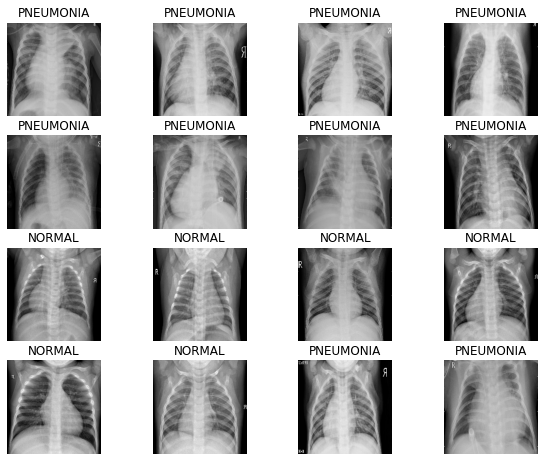

In [61]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 3. CNN 모델링

In [62]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [63]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), # Batch norm 과 Dropout 동시사용. 일반적이지 않은 경우
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [64]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### Imbalanced data 처리

In [65]:
# data의 가중치 조절
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


* Normal의 이미지 수가 Pneumonia의 1/3 정도 밖에 안되기 때문에 가중치를 역으로 normal이 pneumonia 대비 3배 정도 되도록 재설정

### 4. Model 훈련

In [66]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 44s 141ms/step - loss: 0.5366 - accuracy: 0.7208 - precision: 0.9156 - recall: 0.6881 - val_loss: 0.6691 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 36s 138ms/step - loss: 0.2720 - accuracy: 0.8847 - precision: 0.9653 - recall: 0.8767 - val_loss: 1.3204 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 138ms/step - loss: 0.2238 - accuracy: 0.9139 - precision: 0.9692 - recall: 0.9125 - val_loss: 0.3726 - val_accuracy: 0.8317 - val_precision: 0.8169 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1676 - accuracy: 0.9301 - precision: 0.9795 - recall: 0.9243 - val_loss: 0.1811 - val_accuracy: 0.9356 - val_precision: 0.9972 - val_recall: 0.9161
Epoch 5/25
261/261 [==============================] - 36s 138ms/step - loss: 0.1547 - accura

### 5. 결과 확인

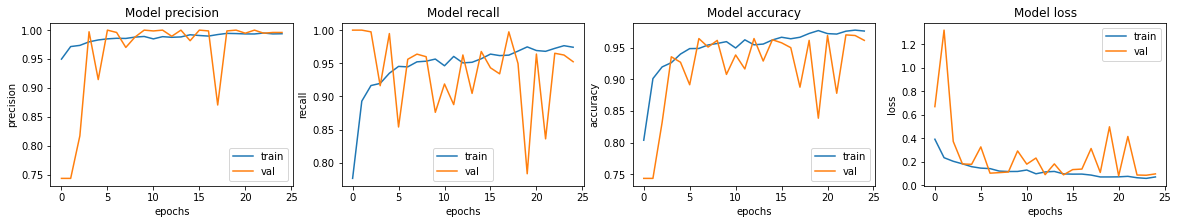

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.9384 - accuracy: 0.8093 - precision: 0.7726 - recall: 0.9846
Loss: 0.9383993148803711,
Accuracy: 0.8092948794364929,
Precision: 0.772635817527771,
Recall: 0.9846153855323792


* Accuracy가 80% 정도 밖에 나오지 않았다.
* 따라서 추가적으로 데이터를 재 조정 하거나 parameter를 재 설정 하여 목표치의 accuracy를 얻을 수 있도록 한다.

### 6. Augmentation

In [58]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### Model 재 훈련

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 45s 143ms/step - loss: 0.5733 - accuracy: 0.7087 - precision: 0.9095 - recall: 0.6742 - val_loss: 0.5756 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 36s 137ms/step - loss: 0.2750 - accuracy: 0.8897 - precision: 0.9645 - recall: 0.8832 - val_loss: 1.1857 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 138ms/step - loss: 0.2059 - accuracy: 0.9158 - precision: 0.9746 - recall: 0.9113 - val_loss: 0.1208 - val_accuracy: 0.9635 - val_precision: 0.9589 - val_recall: 0.9935
Epoch 4/25
261/261 [==============================] - 36s 138ms/step - loss: 0.1943 - accuracy: 0.9206 - precision: 0.9777 - recall: 0.9144 - val_loss: 0.1736 - val_accuracy: 0.9356 - val_precision: 0.9972 - val_recall: 0.9161
Epoch 5/25
261/261 [==============================] - 36s 140ms/step - loss: 0.1702 - accura

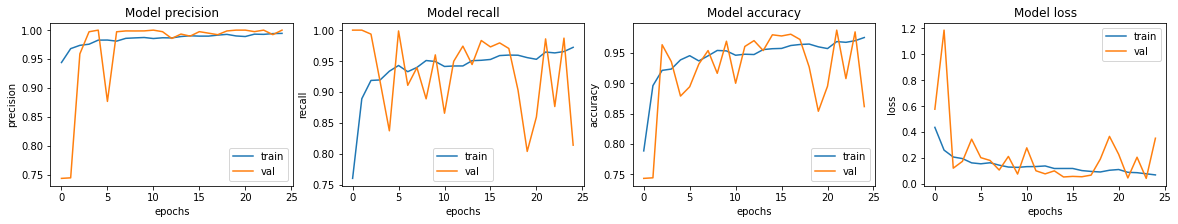

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* validation 그래프를 보면 epochs 3, 9 가 진행되는 단계에서 측정값이 확 낮아지거나 높아지는 현상이 나타난다. 
* 이 단계에 해당하는 데이터들을 정상적으로 구분하지 못하는 것 같고 따라서 batch 조절 등의 추가적인 수정이 필요 해 보인다.

In [69]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.3801 - accuracy: 0.8574 - precision: 0.9123 - recall: 0.8538
Loss: 0.38010063767433167,
Accuracy: 0.8573718070983887,
Precision: 0.9123287796974182,
Recall: 0.8538461327552795


* Augmentation 방식을 도입한 결과 **최종적으로 목표로 했던 85% 정도의 accuracy를 얻을 수 있었다.**
* Batch size 와 epochs 에 따른 추가적인 변화를 확인하기 위해 몇가지 테스트를 더 진행 해 보았다.

### 7. 추가 테스트
#### Batch size 변경 후 test : 16 -> 32

In [140]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 264ms/step - loss: 0.5915 - accuracy: 0.6921 - precision: 0.8860 - recall: 0.6611 - val_loss: 0.6181 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 33s 254ms/step - loss: 0.2310 - accuracy: 0.9092 - precision: 0.9696 - recall: 0.9040 - val_loss: 0.7524 - val_accuracy: 0.7275 - val_precision: 0.7275 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 33s 254ms/step - loss: 0.1865 - accuracy: 0.9315 - precision: 0.9715 - recall: 0.9339 - val_loss: 0.9344 - val_accuracy: 0.7275 - val_precision: 0.7275 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 33s 257ms/step - loss: 0.1435 - accuracy: 0.9521 - precision: 0.9793 - recall: 0.9542 - val_loss: 1.0886 - val_accuracy: 0.7275 - val_precision: 0.7275 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 33s 256ms/step - loss: 0.1566 - accura

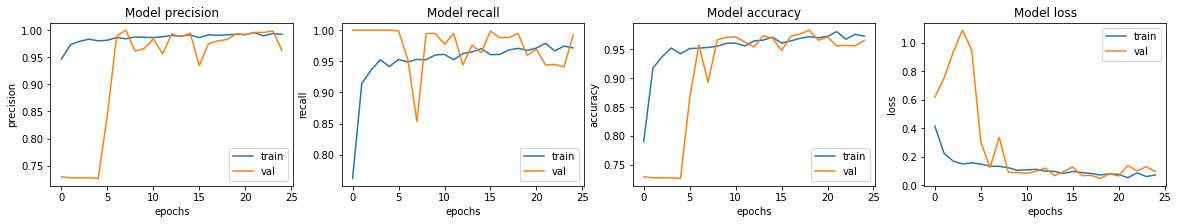

In [141]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [142]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 3s 142ms/step - loss: 1.1456 - accuracy: 0.7067 - precision: 0.6813 - recall: 0.9974
Loss: 1.145648717880249,
Accuracy: 0.7067307829856873,
Precision: 0.6812609434127808,
Recall: 0.9974358677864075


* Accuracy가 오히려 상당히 떨어진 것을 볼 수 있다.
* 따라서 이번에는 batch size를 줄여서 테스트 해보기로 한다.

#### Batch size : 32 -> 8 변경

In [166]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
523/523 [==============================] - 63s 76ms/step - loss: 0.5929 - accuracy: 0.7106 - precision: 0.9000 - recall: 0.6858 - val_loss: 0.8530 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 39s 74ms/step - loss: 0.3283 - accuracy: 0.8575 - precision: 0.9611 - recall: 0.8441 - val_loss: 0.2593 - val_accuracy: 0.8913 - val_precision: 0.9955 - val_recall: 0.8579
Epoch 3/25
523/523 [==============================] - 39s 75ms/step - loss: 0.3140 - accuracy: 0.8596 - precision: 0.9618 - recall: 0.8477 - val_loss: 0.4907 - val_accuracy: 0.8231 - val_precision: 0.9983 - val_recall: 0.7626
Epoch 4/25
523/523 [==============================] - 39s 75ms/step - loss: 0.2609 - accuracy: 0.8846 - precision: 0.9661 - recall: 0.8774 - val_loss: 0.6183 - val_accuracy: 0.7317 - val_precision: 1.0000 - val_recall: 0.6381
Epoch 5/25
523/523 [==============================] - 39s 75ms/step - loss: 0.2631 - accuracy: 0

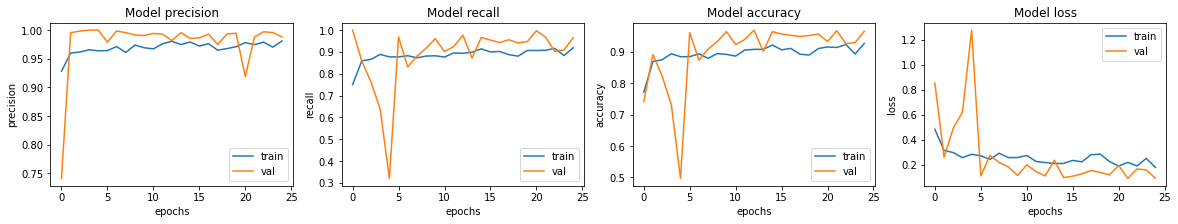

In [169]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [170]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 38ms/step - loss: 0.6865 - accuracy: 0.7644 - precision: 0.7314 - recall: 0.9846
Loss: 0.6865291595458984,
Accuracy: 0.7644230723381042,
Precision: 0.7314285635948181,
Recall: 0.9846153855323792


* 76%의 accuracy를 보인다. 따라서 batch size는 16으로 고정하는 것이 가장 이상적이라고 생각된다.
* 추가 적으로 epochs 수치를 변경하여 테스트 해보기로 한다.

#### 조건 재설정
Batchsize: 8->16 <br>
Epochs : 25 -> 50

In [207]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 43s 138ms/step - loss: 0.4622 - accuracy: 0.7746 - precision: 0.9377 - recall: 0.7450 - val_loss: 0.6765 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 36s 137ms/step - loss: 0.3068 - accuracy: 0.8771 - precision: 0.9624 - recall: 0.8699 - val_loss: 1.0707 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 36s 136ms/step - loss: 0.2541 - accuracy: 0.8972 - precision: 0.9706 - recall: 0.8900 - val_loss: 0.2070 - val_accuracy: 0.9250 - val_precision: 0.9941 - val_recall: 0.9017
Epoch 4/50
261/261 [==============================] - 35s 135ms/step - loss: 0.2493 - accuracy: 0.9084 - precision: 0.9697 - recall: 0.9052 - val_loss: 0.1877 - val_accuracy: 0.9365 - val_precision: 0.9886 - val_recall: 0.9229
Epoch 5/50
261/261 [==============================] - 35s 136ms/step - loss: 0.1794 - accura

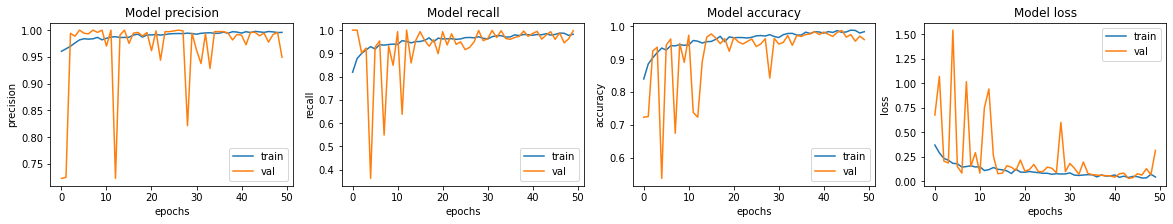

In [208]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [209]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 3.5525 - accuracy: 0.7019 - precision: 0.6771 - recall: 1.0000
Loss: 3.552546501159668,
Accuracy: 0.7019230723381042,
Precision: 0.6770833134651184,
Recall: 1.0


* epochs 수치가 늘어났음에도 오히려 그래프상의 잡음이 더 심해진 것을 볼 수 있다.
* 따라서 굳이 epochs 수치를 변경 할 필요는 없다고 생각 된다.

### 8. 회고

* Normal 대비 pneumonia 를 얼마나 정상적으로 진단 할 수 있는지에 대한 내용이었다.
* 개인적으로 imbalanced data를 처리해 주는 방식이 상당히 유익했다. 일반적으로 이런 질병에 관련 된 데이터 뿐만아니라 여러종류의 imbalanced data들이 존재하고 따라서 이를 처리 해야 할 일들이 많을 것이라 생각 된다. 이럴 때 단순히 데이터의 양을 늘리기 어려운 경우 각 데이터의 weight을 조절하여 비슷한 수준에서 학습이 이뤄지도록 하는 것이 중요할 것이다.
* 처음 train, val data_set을 구분할 때 단순히 셔플만 진행하여 학습시킨 모델을 이용한 결과 최종 accuracy 값이 80% 정도 나오는 것을 확인하였다. 목표가 85% 였기 때문에 학습방식에 변화를 줄 필요가 있었고, lms에서 제시 한 대로 augmentation 방식을 사용하기로 했다.
* 그 결과 목표수치인 85%를 조금 넘는 결과를 얻었다. 하지만 batch_size 또는 epochs의 수정에 따른 결과의 변화가 궁금하였기에 몇 가지 테스트를 추가로 진행 해 보았다.
* batch_size 와 epochs의 값을 수정 해 본 결과 의외로 accuracy 값이 더 낮아지는 현상이 나타났으며 이는 batch_size가 늘어나면 오히려 좀 더 정확한 학습이 일어날 것 이라는 본인의 초기의 예상과는 다른 결과였다.
* 물론 한번의 테스트로 모든 것을 정확하게 알 수는 없지만, batch_size와 epochs의 값이 단순히 크면 좋다거나 작으면 좋다는 식으로 작동하는 것은 아니라는 걸 알 수 있었다. 상황에 맞는 적절한 값을 찾는 것이 항상 중요하다고 생각한다.
* 그리고 데이터의 양을 늘릴 수 없지만 accuracy를 높여야 하는 상황이라면 augmentation과 같은 기존의 이미지를 다양한 형태로 변경시켜주는 방식을 도입하면 어느정도 효과를 볼 수 있다는 것도 알게 되었다. 
* 개인적으로는 기존의 data 와 augmentation이 적용된 data를 합쳐서 하나의 큰 data_set으로 만들어서 학습 시키면 더 정확한 결과를 얻을 수 있을것이라 생각한다.
* 여러가지로 많이 공부가 된 node 였다.